In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

from utils.data_preparation import naive_bayes_preprocessing, bert_preprocessing,electra_preprocessing
from models.naive_bayes import NaiveBayes
from models.bert import Bert,DistilBert
from models.gpt2_roberta_electra import Electra

In [2]:
emotion_labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [1]:
!python main.py

Starting Distilbert search
The number of combinations is: 224
/home/maalih@labos.polymtl.ca/projects/final_project/IFT6289-H25/models/naive_bayes.py:18: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log((feature_counts_per_class + alpha_likelihood) /
2025-04-01 21:04:46,728 - INFO - Starting ELECTRA search
2025-04-01 21:04:46,728 - INFO - Starting ELECTRA search


In [14]:
import pickle
with open('out/nb_grid_search_results.pkl', 'rb') as handle:
    nb_grid_search_results = pickle.load(handle)
print(nb_grid_search_results.head())

   alpha_prior  alpha_likelihood  use_bigrams  remove_stopwords  val_accuracy
0           10               0.2         True             False      0.553897
1            1               0.2         True             False      0.553897
2            0               0.2         True             False      0.553897
3          100               0.2         True             False      0.553068
4            1               1.0         True              True      0.552239


Best Naive Bayes params from the grid search:
alpha_prior               10
alpha_likelihood         0.2
use_bigrams             True
remove_stopwords       False
val_accuracy        0.553897
Name: 0, dtype: object
-------- Naive Bayes results on test set ------
              precision    recall  f1-score   support

           0     0.4110    0.4470    0.4283       217
           1     0.6585    0.5047    0.5714       214
           2     0.5775    0.6866    0.6274       217
           3     0.3913    0.4225    0.4063       213
           4     0.7023    0.6927    0.6975       218
           5     0.5933    0.5741    0.5835       216
           6     0.5077    0.4670    0.4865       212

    accuracy                         0.5428      1507
   macro avg     0.5488    0.5421    0.5430      1507
weighted avg     0.5492    0.5428    0.5435      1507

Micro f1 score:  0.5428002654280026


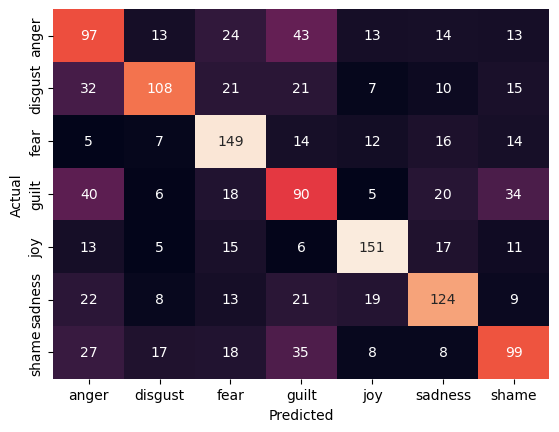

In [15]:
# take params from best model
best_params = nb_grid_search_results.iloc[0]
print(f"Best Naive Bayes params from the grid search:\n{best_params}")

processed_data, vectorizer = naive_bayes_preprocessing(
    remove_stopwords=best_params['remove_stopwords'],
    use_bigrams=best_params['use_bigrams']
)
X_train, y_train = processed_data['train']
X_test, y_test = processed_data['test']

nb = NaiveBayes()
nb.fit(X_train, y_train, alpha_prior=best_params['alpha_prior'],
                         alpha_likelihood=best_params['alpha_likelihood'])
y_pred = nb.predict(X_test)

print('-------- Naive Bayes results on test set ------')
print(classification_report(y_test, y_pred, digits=4))
print('Micro f1 score: ', f1_score(y_test, y_pred, average='micro'))
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.xaxis.set_ticklabels(emotion_labels); ax.yaxis.set_ticklabels(emotion_labels);
plt.savefig('./out/figures/nb_model_confmatrix.png', dpi=400)
plt.show()

In [16]:
feature_names = vectorizer.get_feature_names_out()
class_log_probabilities = nb.feature_log_prob_
class_names = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

for i, class_probabilities in enumerate(class_log_probabilities):
    # sort features by their log prob
    sorted_features = np.argsort(class_probabilities)

    # get the top n feature
    top_features = sorted_features[-5:][::-1]
    top_scores = class_probabilities[top_features]
    top_scores = np.exp(top_scores)
    top_feature_names = feature_names[top_features]

    print(f"Class {i} ({class_names[i]}):", end=' ')
    for feature_name, score in zip(top_feature_names, top_scores):
        print(f"'{feature_name}' ({score:.4f})", end=' ')
    print()


Class 0 (anger): 'the' (0.0142) 'my' (0.0139) 'to' (0.0132) 'and' (0.0113) 'was' (0.0101) 
Class 1 (disgust): 'the' (0.0162) 'and' (0.0113) 'was' (0.0100) 'to' (0.0100) 'of' (0.0091) 
Class 2 (fear): 'the' (0.0190) 'was' (0.0172) 'and' (0.0137) 'to' (0.0112) 'in' (0.0089) 
Class 3 (guilt): 'the' (0.0139) 'to' (0.0136) 'my' (0.0135) 'and' (0.0120) 'was' (0.0094) 
Class 4 (joy): 'the' (0.0162) 'when' (0.0123) 'my' (0.0123) 'was' (0.0113) 'and' (0.0100) 
Class 5 (sadness): 'my' (0.0151) 'the' (0.0135) 'was' (0.0106) 'when' (0.0105) 'to' (0.0103) 
Class 6 (shame): 'the' (0.0135) 'my' (0.0122) 'to' (0.0121) 'was' (0.0116) 'and' (0.0115) 


In [4]:
!python main.py

Starting Distilbert search
The number of combinations is: 8
Training Epoch 1: 100%|███████████████████████| 151/151 [00:07<00:00, 20.43it/s]
  Average training loss: 1.3899100616278237
Training Epoch 2: 100%|███████████████████████| 151/151 [00:07<00:00, 20.78it/s]
  Average training loss: 0.7533243949839611
Training Epoch 3: 100%|███████████████████████| 151/151 [00:07<00:00, 20.77it/s]
  Average training loss: 0.42236054664021294
Training Epoch 4: 100%|███████████████████████| 151/151 [00:07<00:00, 20.76it/s]
  Average training loss: 0.21490679234759696
Training Epoch 5: 100%|███████████████████████| 151/151 [00:07<00:00, 20.73it/s]
  Average training loss: 0.11942320995476861
Training Epoch 1: 100%|███████████████████████| 151/151 [00:07<00:00, 20.70it/s]
  Average training loss: 1.4278844827847765
Training Epoch 2: 100%|███████████████████████| 151/151 [00:07<00:00, 20.65it/s]
  Average training loss: 0.7681729975125647
Training Epoch 3: 100%|███████████████████████| 151/151 [00:07

In [5]:
with open('out/_grid_search_results_last_layers.pkl', 'rb') as handle:
    nb_grid_search_results = pickle.load(handle)
print(nb_grid_search_results.head())

   epochs  batch_size       lr  weight_decay  fine_tune_last_layers  \
0       5          32  0.00005         0.010                  False   
1       5          32  0.00005         0.001                  False   
2       5          64  0.00005         0.010                  False   
3       8          32  0.00005         0.010                  False   
4       8          64  0.00005         0.010                  False   

   val_accuracy  
0      0.687396  
1      0.681592  
2      0.676617  
3      0.675788  
4      0.674959  


In [6]:
bert_processed_data, tokenizer = bert_preprocessing()
input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
input_ids_val, attention_mask_val, y_val = bert_processed_data['validation']
input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

train_dataset = TensorDataset(input_ids_train, attention_mask_train, y_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, y_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test)

Best BERT parameters:
epochs                          5
batch_size                     32
lr                        0.00005
weight_decay                 0.01
fine_tune_last_layers       False
val_accuracy             0.687396
Name: 0, dtype: object


Training Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:07<00:00, 20.67it/s]


  Average training loss: 1.386246780686031


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:07<00:00, 20.73it/s]


  Average training loss: 0.7635764351349004


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:07<00:00, 20.73it/s]


  Average training loss: 0.446754570137586


Training Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:07<00:00, 20.71it/s]


  Average training loss: 0.23960879839808735


Training Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:07<00:00, 20.72it/s]


  Average training loss: 0.12568323141494334

-------- BERT Model Results on Test Set ------

              precision    recall  f1-score   support

           0     0.5945    0.5945    0.5945       217
           1     0.7143    0.6542    0.6829       214
           2     0.7739    0.8203    0.7964       217
           3     0.6652    0.6901    0.6774       213
           4     0.9065    0.8899    0.8981       218
           5     0.7095    0.6898    0.6995       216
           6     0.5890    0.6085    0.5986       212

    accuracy                         0.7074      1507
   macro avg     0.7076    0.7068    0.7068      1507
weighted avg     0.7082    0.7074    0.7074      1507

Micro f1 score: 0.7073656270736562


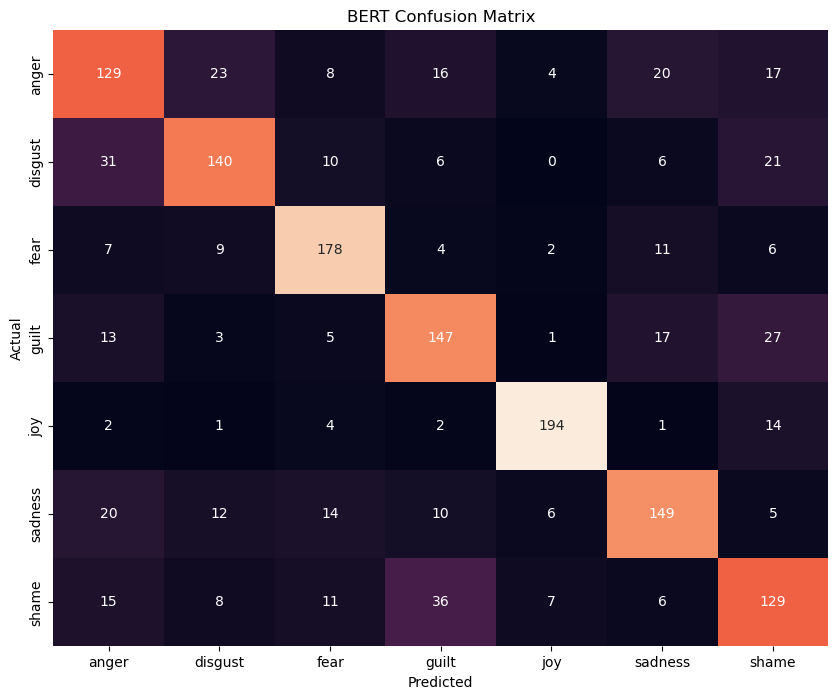

In [9]:
# Load the best BERT model results
with open('out/_grid_search_results_last_layers.pkl', 'rb') as handle:
    bert_results = pickle.load(handle)

# Get the best parameters
best_params = bert_results.iloc[0]
print(f"Best BERT parameters:\n{best_params}")

# Prepare data with best parameters
bert_processed_data, tokenizer = bert_preprocessing()
input_ids_train, attention_mask_train, y_train = bert_processed_data['train']
input_ids_test, attention_mask_test, y_test = bert_processed_data['test']

# Create datasets
train_dataset = TensorDataset(input_ids_train, attention_mask_train, y_train)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test)

# Create data loaders with best batch size - convert to int
batch_size = int(best_params['batch_size'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize and train BERT with best parameters
bert = Bert()
bert.fit(
    train_loader, 
    epochs=int(best_params['epochs']),
    lr=float(best_params['lr']),
    weight_decay=float(best_params['weight_decay']),
    fine_tune_last_layers=bool(best_params['fine_tune_last_layers'])
)

# Get predictions
y_pred = bert.predict(test_loader)

# Print detailed classification report
print('\n-------- BERT Model Results on Test Set ------\n')
print(classification_report(y_test, y_pred, digits=4))
print(f'Micro f1 score: {f1_score(y_test, y_pred, average="micro")}')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
ax = plt.gca()
ax.xaxis.set_ticklabels(emotion_labels)
ax.yaxis.set_ticklabels(emotion_labels)
plt.savefig('./out/figures/bert_confmatrix.png', dpi=400)
plt.show()